In [1]:
import pandas as pd
import dask.dataframe as dd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
import pickle

/Users/melodytan/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Paths

In [2]:
# Data
processed_dir = os.path.join( "..", "data", "processed")
final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')
minority_users_dt_pq = os.path.join(processed_dir, 'minority_users_dt_smote.parquet')

# Model
models_dir = os.path.join( "..", "models","models")
model_dump_path = os.path.join(models_dir, 'dt_smote_model.pkl')

# Figures
figures_dir = os.path.join( "..", "materials", "reports", "figures", "3B")
dt_smote_confusion_matrix_path = os.path.join(figures_dir, 'dt_smote_confusion_matrix.png')
dt_smote_feature_importance_path = os.path.join(figures_dir, 'dt_smote_feature_importance.png')
dt_smote_visualisation_path = os.path.join(figures_dir, 'dt_smote_visualisation.png')
dt_smote_train_confidence_score_path = os.path.join(figures_dir, 'dt_smote_train_confidence_score.png')
dt_smote_test_confidence_score_path = os.path.join(figures_dir, 'dt_smote_test_confidence_score.png')

Import Dataset

In [3]:
# Read the multi-part Parquet dataset
fds = pd.read_parquet(final_dataset_path)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
__null_dask_index__,,,,,,,,,,,,,,,,,,,
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,False
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,False
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,False
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,False
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,False
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,False
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,False


# Decision Tree / Random Forest

In [4]:
X = fds.drop(columns = ['user', 'malicious'])
y = fds.malicious

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({False: 1574, True: 26})


**SMOTE Oversampling**

In [5]:
# transform the dataset
oversample = SMOTE(sampling_strategy = 0.4, random_state = 42) #sampling_strategy=0.8
resampled_X_train, resampled_y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(resampled_y_train))

Train Labels after Resampling
Counter({False: 1574, True: 629})


**Feature Normalisation**

In [6]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(resampled_X_train)
X_test_scaled = scaler.transform(X_test)

y_train = resampled_y_train

**Hyperparameter Tuning**

In [7]:
dt = DecisionTreeClassifier(random_state = 42)
# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 8, 10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 3, 5],
    # 'criterion': ['gini', 'entropy', 'log_loss'], gini
    # 'splitter': ['best', 'random'], best
    'max_features': ['sqrt', 'log', None],
    # 'min_weight_fraction_leaf': [0.0, 0.1, 0.2], 0
    # 'max_leaf_nodes': [None, 2, 4],
    # 'min_impurity_decrease': [0.0, 0.1, 0.2], 0
    'class_weight': ['balanced', None],
    'ccp_alpha': [0.0, 0.01, 0.2]
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(dt, param_grid)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_dt = grid_search.best_estimator_
test_score = best_dt.score(X_test_scaled, y_test)
print("Test Set Score:", test_score)


Best Hyperparameters: {'ccp_alpha': 0.0, 'class_weight': None, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best Score: 0.9809379509379511
Test Set Score: 0.9725


/Users/melodytan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/melodytan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/melodytan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/melodytan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_para

**Model Evaluation after Tuning**

Accuracy: 97.25%
Precision = 18.18%
Recall = 50.00%
f-1 score = 26.67%

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.98      0.99       396
        True       0.18      0.50      0.27         4

    accuracy                           0.97       400
   macro avg       0.59      0.74      0.63       400
weighted avg       0.99      0.97      0.98       400



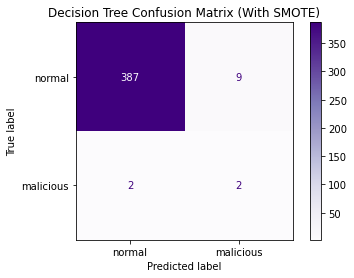

In [16]:
# Evaluate the model
best_dt.fit(X_train_scaled, y_train)
y_pred = best_dt.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision = {:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall = {:.2f}%".format(recall_score(y_test, y_pred)*100))
print("f-1 score = {:.2f}%".format(f1_score(y_test, y_pred)*100))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Malicious'])
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot(cmap=plt.cm.Purples)
plt.title('Decision Tree Confusion Matrix (With SMOTE)')
plt.savefig(dt_smote_confusion_matrix_path)
plt.show()

AUC score: 0.7386363636363636


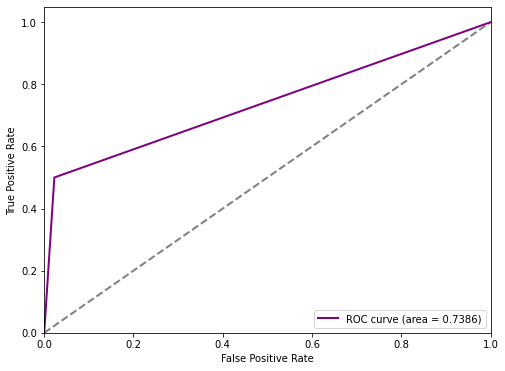

In [9]:
# ROC - AUC
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    plt.figure(figsize=(8, 6))
    #y_prob = best_dt.predict_proba(X_test_scaled)[::,1]
    dt_fpr, dt_tpr, thresholds = roc_curve(true_y, y_prob)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, color='purple', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.legend(loc="lower right")

    # plt.legend()

plot_roc_curve(y_test, y_pred)
print(f'AUC score: {roc_auc_score(y_test, y_pred)}')

**Feature Importance**

<AxesSubplot:>

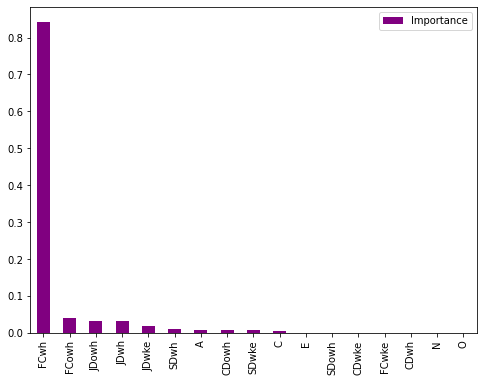

In [10]:
feat_importances = pd.DataFrame(best_dt.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6), color = "purple")
plt.title('Decision Tree Feature Importance (With SMOTE)')
plt.savefig(dt_smote_feature_importance_path)
plt.show()

**Visualise Graph**

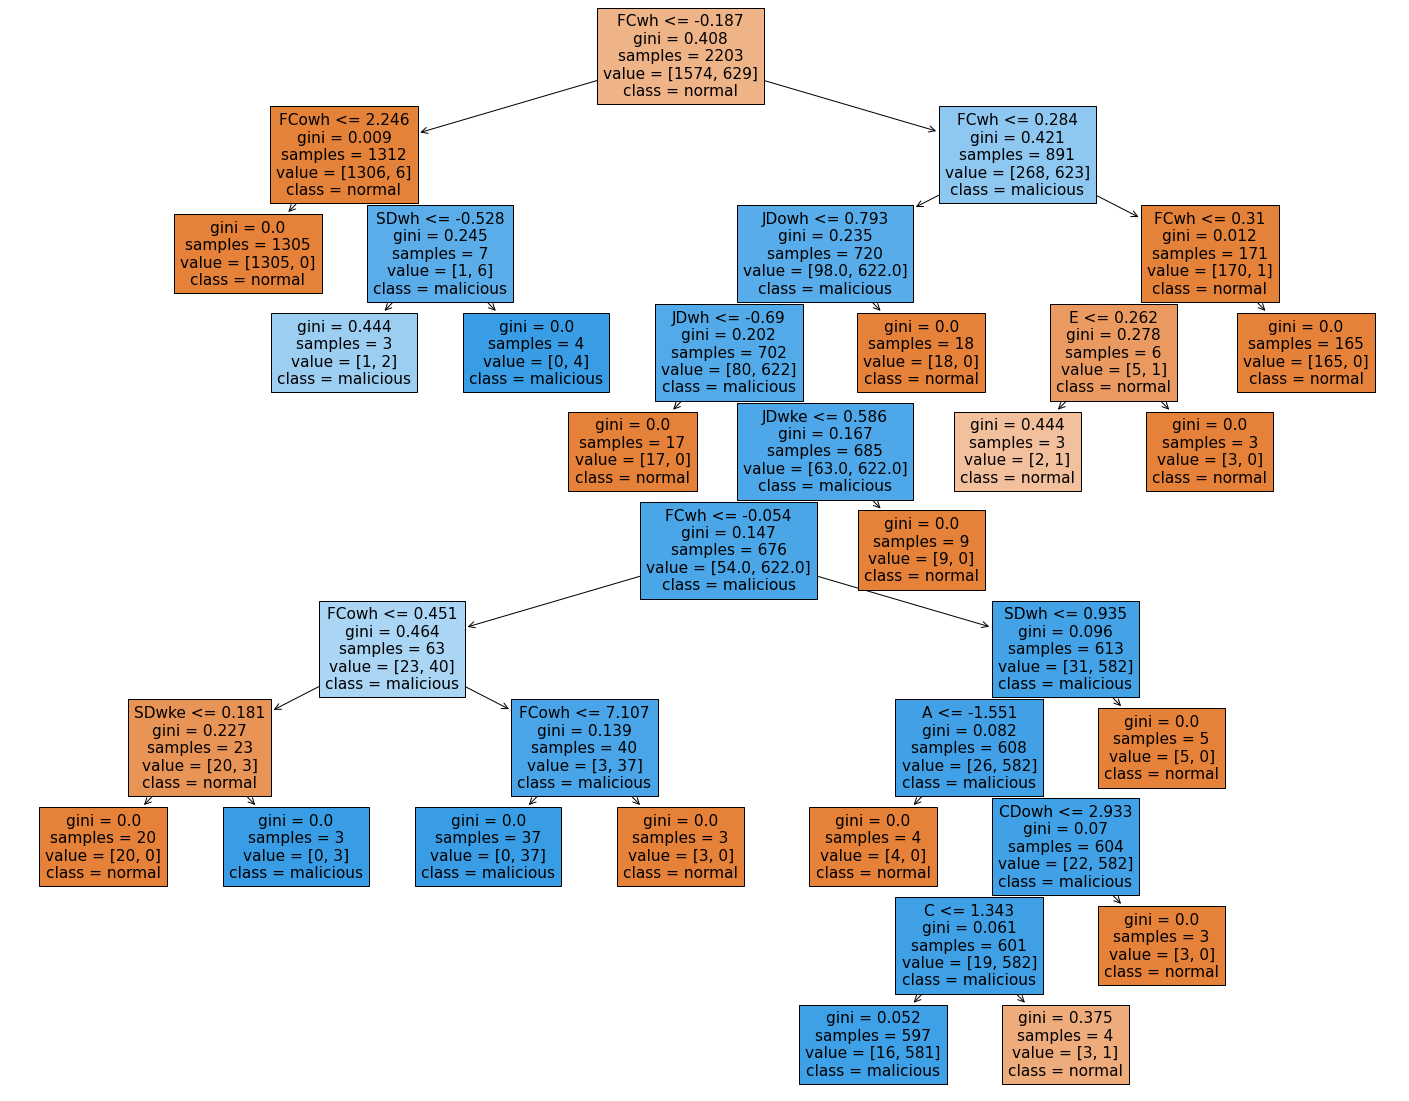

In [11]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_dt, 
                   feature_names=X_train.columns.tolist(),  
                   class_names=["normal","malicious"],
                   filled=True)
plt.title('Decision Tree Visualisation (With SMOTE)')
plt.savefig(dt_smote_visualisation_path)
plt.show()

**Confidence Score: Using Gini**
- A higher impurity indicates a higher risk or uncertainty in the classification decision made by that node. Hence, lower confidence score
- Sum Gini at nodes in decision path, weighted according to number of samples in a node

In [12]:


def get_decision_paths(clf, X):
    node_indicator = clf.decision_path(X)
    decision_paths_matrix = node_indicator.toarray()
    decision_paths_nodes = list([np.where(row == 1)[0].tolist() for row in decision_paths_matrix])

    return decision_paths_nodes
    
def multiply_gini(clf, decision_paths):
    gini_paths = []

    for path in decision_paths:
        gini_nodes = []

        for node in path:
            gini_nodes.append(clf.tree_.n_node_samples[node] * clf.tree_.impurity[node])
        
        gini_paths.append(sum(gini_nodes))

    return np.array(gini_paths).reshape(-1, 1)

def get_confidence_score(clf, decision_paths):
    
    gini = multiply_gini(best_dt, decision_paths)
    scalar = MinMaxScaler(feature_range=(0, 1))
    risk_scores = scalar.fit_transform(gini) # 0 means low risk, 1 means high risk
    confidence_scores = 1 - risk_scores # o means low confidence, 1 means high confidence

    return confidence_scores

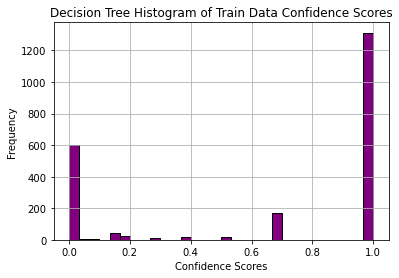

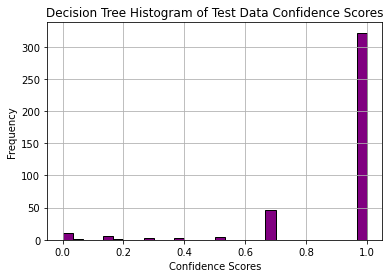

In [18]:
train_decision_paths = get_decision_paths(best_dt, X_train_scaled)
test_decision_paths = get_decision_paths(best_dt, X_test_scaled)


train_confidence_scores = get_confidence_score(best_dt, train_decision_paths)
test_confidence_scores = get_confidence_score(best_dt, test_decision_paths)

# Plot histogram
plt.hist(train_confidence_scores, bins=30, edgecolor='black', color = "purple")  # Adjust bins as needed
plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title('Decision Tree Histogram of Train Data Confidence Scores')
plt.grid(True)
plt.savefig(dt_smote_train_confidence_score_path)
plt.show()

plt.hist(test_confidence_scores, bins=30, edgecolor='black', color = "purple")  # Adjust bins as needed
plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title('Decision Tree Histogram of Test Data Confidence Scores')
plt.grid(True)
plt.savefig(dt_smote_test_confidence_score_path)
plt.show()

# Export Model

In [15]:
pickle.dump(best_dt, open(model_dump_path,'wb'))

FileNotFoundError: [Errno 2] No such file or directory: '../models/models/dt_smote_model.pkl'

#  Our Prediction and the Confidence Associated with it

## Helper Functions

In [ ]:
def df_toparquet(pdf,path):
    ddf = dd.from_pandas(pdf)
    # Export the DataFrame to a parquet file=
    ddf.to_parquet(path, engine='pyarrow')

In [ ]:
def refactored_dataset(df):
    minority_X_test = df
    minority_data = fds.iloc[minority_X_test.index].reset_index(drop = True)
    minority_data['Actual'] = minority_data['malicious']
    minority_data['Prediction'] = y_pred

    # Get decision path
    minority_decision_paths = get_decision_paths(best_dt, X_test_scaled)
    minority_data['Decision Path'] = minority_decision_paths
    # Get confidence score
    minority_data['GINI Confidence of Prediction'] = get_confidence_score(best_dt, minority_decision_paths)


    # Get probabilities of classification
    prob = best_dt.predict_proba(X_test_scaled)
    probs_df = pd.DataFrame(prob, columns=['normal_prob', 'malicious_prob'])
    minority_data = pd.concat([minority_data, probs_df], axis=1)

    minority_data = minority_data.drop(columns =  ['O', 'C', 'E', 'A', 'N', 'FCwke', 'FCowh', 'FCwh', 'SDwke',
        'SDowh', 'SDwh', 'CDwke', 'CDowh', 'CDwh', 'JDwke', 'JDowh', 'JDwh','malicious'])
    return minority_data
refactored_df = refactored_dataset(X_test)
df_toparquet(refactored_df,minority_users_dt_pq)
refactored_df

,user,Actual,Prediction,Decision Path,GINI Confidence of Prediction,normal_prob,malicious_prob
0,VAH1292,False,False,"[0, 1, 2]",1.000000,1.000000,0.000000
1,CJL0143,False,False,"[0, 1, 2]",1.000000,1.000000,0.000000
2,MMB1967,False,False,"[0, 1, 2]",1.000000,1.000000,0.000000
3,IVS1411,False,False,"[0, 1, 2]",1.000000,1.000000,0.000000
4,MEB1743,False,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.000000,0.026801,0.973199
...,...,...,...,...,...,...,...
395,JIG1593,False,False,"[0, 1, 2]",1.000000,1.000000,0.000000
396,MDL0294,False,False,"[0, 1, 2]",1.000000,1.000000,0.000000
397,SSG0726,False,False,"[0, 1, 2]",1.000000,1.000000,0.000000
398,BWJ1539,False,False,"[0, 6, 7, 8, 10, 28]",0.287662,1.000000,0.000000


**Study Minority Instances**
- TP / FN / FP

Get data of minority users

In [ ]:
def get_minority_tables(y_pred_value, y_test_value,df):
    # Get rows of minority data
    minority_data = df[(df['Actual'] == y_test_value) & (df['Prediction'] == y_pred_value)]
    display(minority_data)

In [ ]:
print("False Positives")
get_minority_tables(1, 0,refactored_df)

print("False Negatives")
get_minority_tables(0, 1,refactored_df)

print("True Positives")
get_minority_tables(1,1,refactored_df)


False Positives


,user,Actual,Prediction,Decision Path,GINI Confidence of Prediction,normal_prob,malicious_prob
4,MEB1743,False,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.0,0.026801,0.973199
20,GGD1545,False,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.0,0.026801,0.973199
38,KCR1118,False,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.0,0.026801,0.973199
146,GBV0440,False,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.0,0.026801,0.973199
180,MCV1046,False,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.0,0.026801,0.973199
192,NBL1490,False,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.0,0.026801,0.973199
239,EAM1308,False,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.0,0.026801,0.973199
307,MKC0869,False,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.0,0.026801,0.973199
355,ERM1590,False,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.0,0.026801,0.973199


False Negatives


,user,Actual,Prediction,Decision Path,GINI Confidence of Prediction,normal_prob,malicious_prob
224,TNB1616,True,False,"[0, 1, 2]",1.0,1.0,0.0
318,TMT0851,True,False,"[0, 1, 2]",1.0,1.0,0.0


True Positives


,user,Actual,Prediction,Decision Path,GINI Confidence of Prediction,normal_prob,malicious_prob
60,OKM1092,True,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.0,0.026801,0.973199
290,MCP0611,True,True,"[0, 6, 7, 8, 10, 11, 19, 20, 22, 23, 24]",0.0,0.026801,0.973199


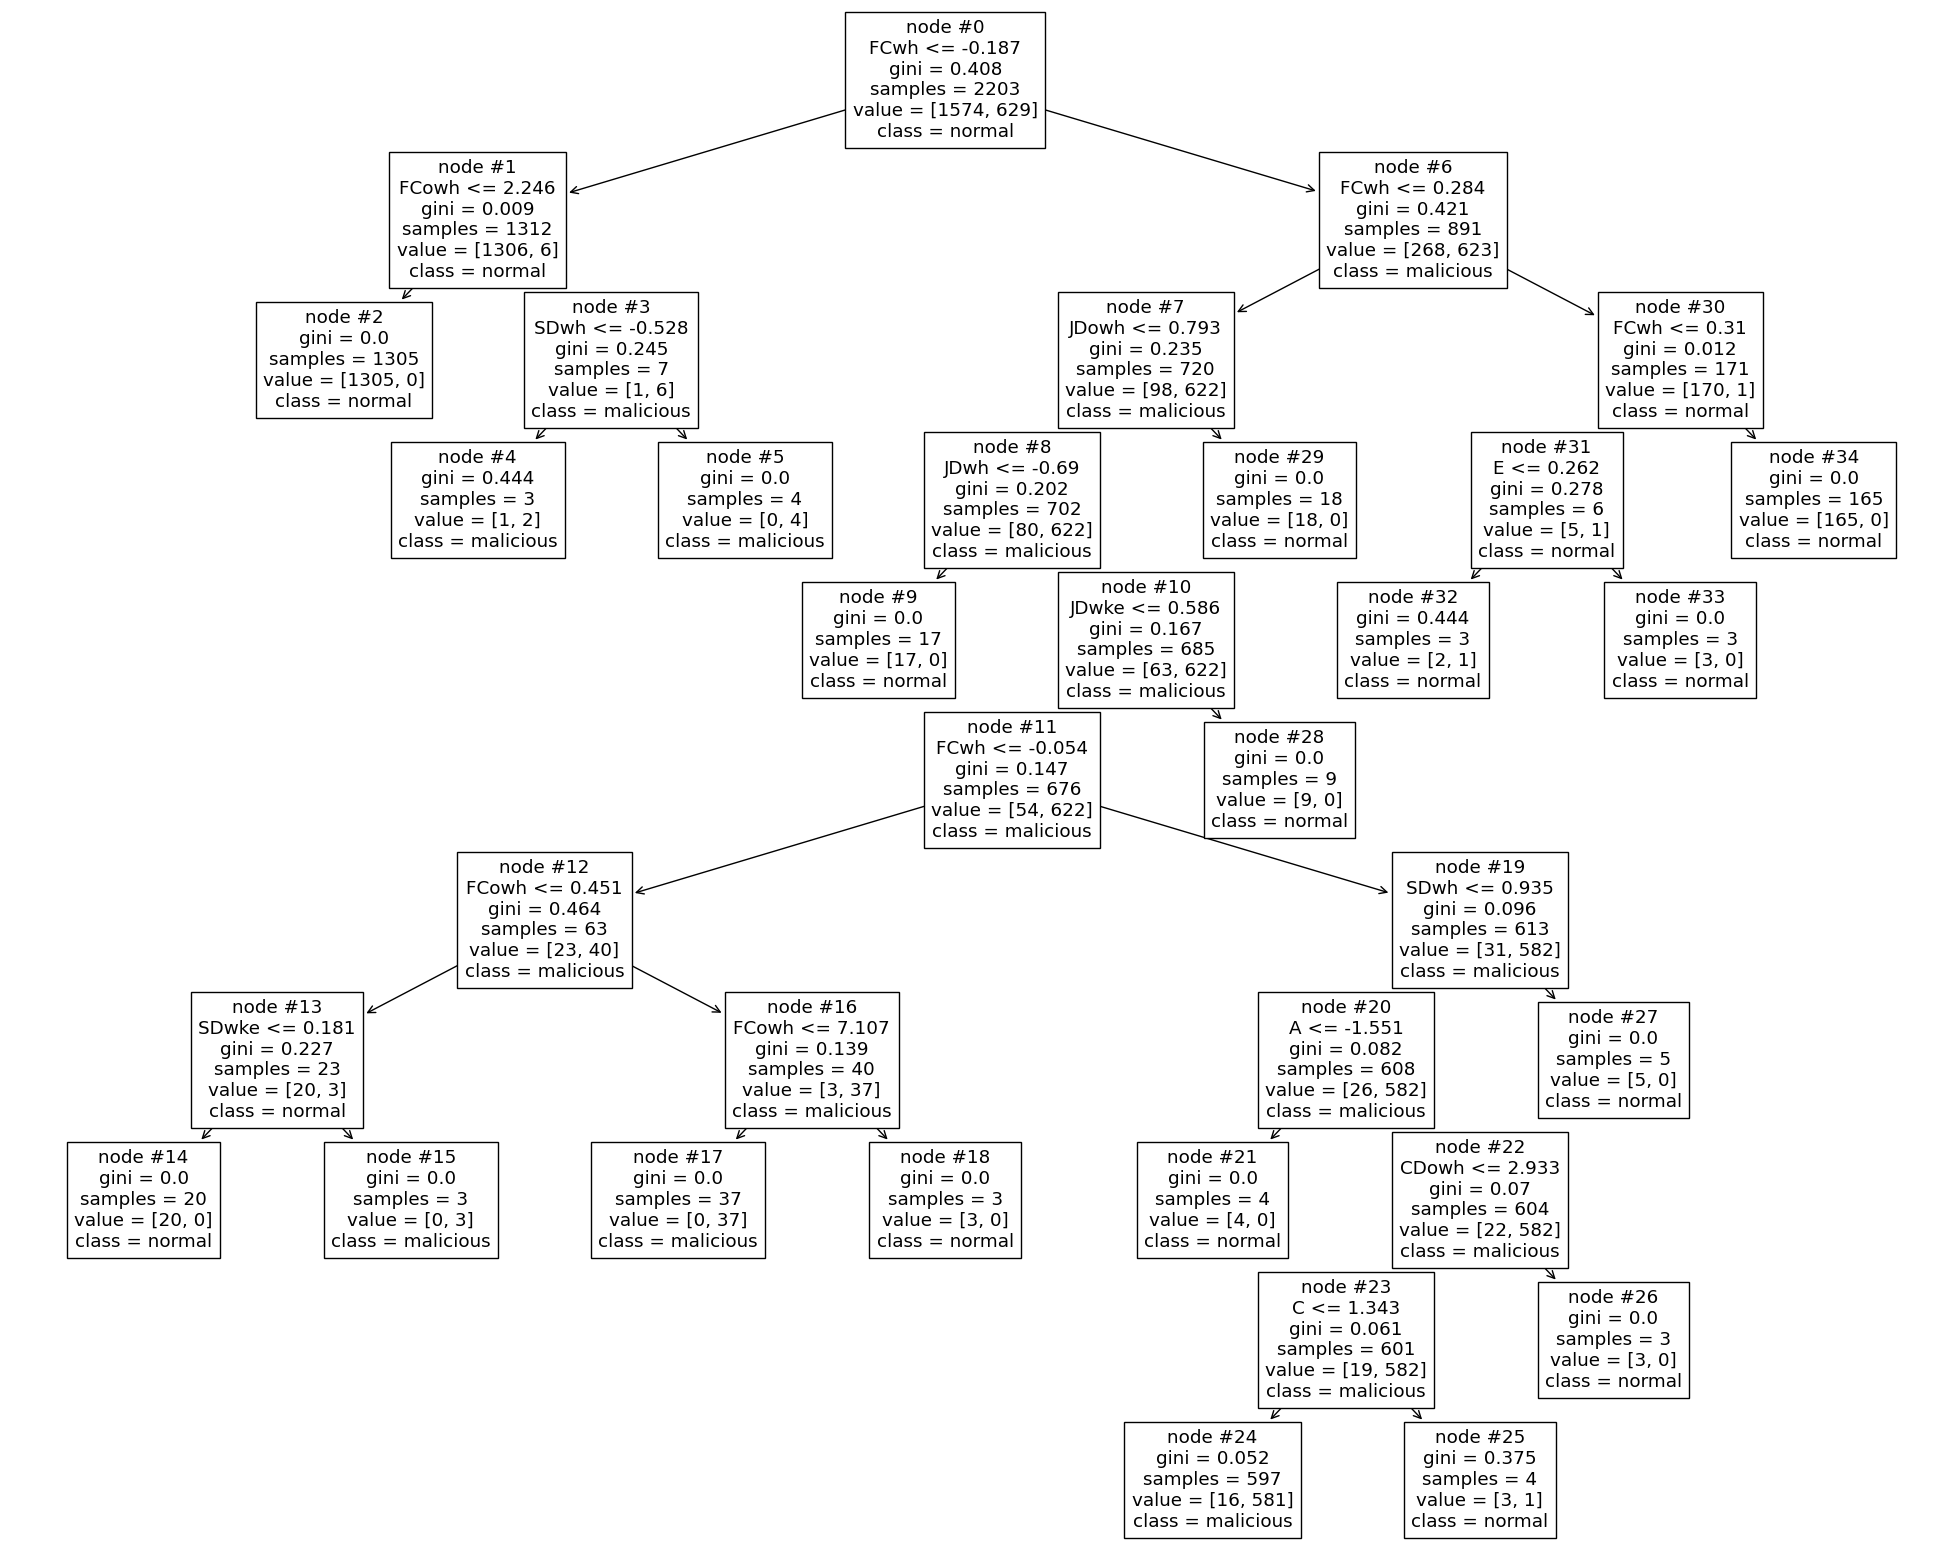

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_dt, 
                   feature_names=X_train.columns.tolist(),  
                   class_names=["normal","malicious"],
                   node_ids = True)